In [77]:
# Importations & définition des variables
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.patches import Patch
import plotly.graph_objects as go
import matplotlib

# Chargement des données
fichier = "Donnees_IA_2025.xlsx"
data = pd.read_excel(fichier)

data.columns = data.columns.str.strip()  # Nettoyage des noms de colonnes

data.head()

,Ordre,Code,Classe,Nom,Nom détaillé,Pays,Année récolte,Date mesure,MS % brut,PB % brut,...,ED porc croissance (kcal) kcal/kg brut,EM porc croissance (kcal) kcal/kg brut,EN porc croissance (kcal) kcal/kg brut,EMAn coq (kcal) kcal/kg brut,EMAn poulet (kcal) kcal/kg brut,UFL 2018 par kg brut,UFV 2018 par kg brut,PDIA 2018 g/kg brut,PDI 2018 g/kg brut,BalProRu 2018 g/kg brut
0,1,657397,Céréales,Avoine,Avoine,Canada,1976-01-01,1976-01-01,87.000000,9.5,...,2460,2380,1850,2610,2480,0.81,0.76,17,62,-10.0
1,2,657400,Céréales,Avoine,Avoine,Canada,1976-01-01,1976-01-01,87.000000,11.9,...,2580,2480,1880,2590,2460,0.88,0.85,22,69,5.0
2,3,657402,Céréales,Avoine,Avoine,Canada,1976-01-01,1976-01-01,87.400002,12.2,...,2760,2660,2030,2690,2560,0.95,0.92,22,70,6.0
3,4,657404,Céréales,Avoine,Avoine,Canada,1976-01-01,1976-01-01,88.800003,10.8,...,2150,2060,1500,2080,1950,0.77,0.72,20,65,-0.5
4,5,657405,Céréales,Avoine,Avoine,Canada,1976-01-01,1976-01-01,88.300003,11.6,...,2690,2590,2000,2750,2620,0.92,0.89,21,68,3.0


In [78]:
# Définition des variables quantitatives, cibles et qualitatives
vars_expl = [
    "MS % brut", "PB % brut", "CB % brut", "MGR % brut", "MM % brut",
    "NDF % brut", "ADF % brut", "Lignine % brut", "Amidon % brut", "Sucres % brut"
]

vars_cibles = [
    "EB (kcal) kcal/kg brut", "ED porc croissance (kcal) kcal/kg brut", "EM porc croissance (kcal) kcal/kg brut",
    "EN porc croissance (kcal) kcal/kg brut", "EMAn coq (kcal) kcal/kg brut", "EMAn poulet (kcal) kcal/kg brut",
    "UFL 2018 par kg brut", "UFV 2018 par kg brut", "PDIA 2018 g/kg brut", "PDI 2018 g/kg brut", "BalProRu 2018 g/kg brut"
]

vars_qual = ["Classe", "Nom"]

# Conversion des variables de composition et énergétiques en numérique
for col in vars_expl + vars_cibles:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors="coerce")

# Dictionnaire de noms réels -> noms simplifiés pour affichage
noms_simplifies = {
    "MS % brut": "MS",
    "PB % brut": "PB",
    "CB % brut": "CB",
    "MGR % brut": "MGR",
    "MM % brut": "MM",
    "NDF % brut": "NDF",
    "ADF % brut": "ADF",
    "Lignine % brut": "Lignine",
    "Amidon % brut": "Amidon",
    "Sucres % brut": "Sucres",
    "EB (kcal) kcal/kg brut": "EB",
    "ED porc croissance (kcal) kcal/kg brut": "ED porc",
    "EM porc croissance (kcal) kcal/kg brut": "EM porc",
    "EN porc croissance (kcal) kcal/kg brut": "EN porc",
    "EMAn coq (kcal) kcal/kg brut": "EMAn coq",
    "EMAn poulet (kcal) kcal/kg brut": "EMAn poulet",
    "UFL 2018 par kg brut": "UFL",
    "UFV 2018 par kg brut": "UFV",
    "PDIA 2018 g/kg brut": "PDIA",
    "PDI 2018 g/kg brut": "PDI",
    "BalProRu 2018 g/kg brut": "BalProRu"
}

# Aperçu des données
print(f"Nombre de variables explicatives : {len(vars_expl)}")
print(f"Nombre d'observations total : {data.shape[0]}")
print(f"Nombre de valeurs manquantes : {data.isnull().sum().sum()}")

Nombre de variables explicatives : 10
Nombre d'observations total : 3998
Nombre de valeurs manquantes : 0


In [117]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

# ============================================================================
# FONCTIONS
# ============================================================================

def prepare_data_random_split(data, features, target_cols, test_size=0.2, random_state=42):
    """
    Prépare les données avec un split aléatoire train/test.
    
    Args:
        data: DataFrame avec les données
        features: Liste des colonnes features
        target_cols: Liste des colonnes cibles
        test_size: Proportion du test set
        random_state: Graine aléatoire
    
    Returns:
        X_train, X_test, y_train, y_test
    """
    X = data[features].copy()
    y = data[target_cols].copy()
    return train_test_split(X, y, test_size=test_size, random_state=random_state)


def prepare_data_hide_one_per_class(data, features, target_cols, class_col, random_state=42):
    """
    Prépare les données en cachant 1 NOM par classe (tous les échantillons de ce nom) à l'entraînement.
    
    Args:
        data: DataFrame avec les données
        features: Liste des colonnes features
        target_cols: Liste des colonnes cibles
        class_col: Nom de la colonne classe
        random_state: Graine aléatoire
    
    Returns:
        X_train, X_test, y_train, y_test, classe_test, nom_test
    """
    np.random.seed(random_state)
    indices_test_list = []
    
    # Pour chaque classe, sélectionner 1 nom aléatoire
    for classe in data[class_col].unique():
        # Données de cette classe
        classe_data = data[data[class_col] == classe]
        # Noms uniques dans cette classe
        noms_uniques = classe_data['Nom'].unique()
        # Sélectionner 1 nom aléatoire
        nom_selectionne = np.random.choice(noms_uniques, 1)[0]
        # Récupérer TOUS les indices avec ce nom
        indices_nom = classe_data[classe_data['Nom'] == nom_selectionne].index
        indices_test_list.extend(indices_nom)
    
    indices_test = pd.Index(indices_test_list)
    indices_train = data.index.difference(indices_test)
    
    X_train = data.loc[indices_train, features].copy()
    y_train = data.loc[indices_train, target_cols].copy()
    
    X_test = data.loc[indices_test, features].copy()
    y_test = data.loc[indices_test, target_cols].copy()
    
    classe_test = data.loc[indices_test, class_col].values
    nom_test = data.loc[indices_test, "Nom"].values
    
    return X_train, X_test, y_train, y_test, classe_test, nom_test


def add_encoded_feature(X_train, X_test, data, feature_name, indices_train, indices_test):
    """
    Ajoute une feature encodée (ex: Classe) à X_train et X_test.
    Apprend l'encodage sur toutes les classes du dataset original.
    
    Args:
        X_train: DataFrame train
        X_test: DataFrame test
        data: DataFrame original
        feature_name: Nom de la feature à encoder
        indices_train: Indices d'entraînement
        indices_test: Indices de test
    
    Returns:
        X_train, X_test (modifiés avec la feature encodée)
    """
    le = LabelEncoder()
    
    # Apprendre l'encodage sur TOUTES les classes du dataset original
    all_classes = data[feature_name].values
    le.fit(all_classes)
    
    # Encoder les données train et test
    feature_train = data.loc[indices_train, feature_name].values
    feature_test = data.loc[indices_test, feature_name].values
    
    encoded_train = le.transform(feature_train)
    encoded_test = le.transform(feature_test)
    
    X_train[f"{feature_name}_encoded"] = encoded_train
    X_test[f"{feature_name}_encoded"] = encoded_test
    
    return X_train, X_test


def train_xgboost_models(X_train, X_test, y_train, y_test, target_cols, 
                          noms_simplifies, random_state=42):
    """
    Entraîne des modèles XGBoost pour chaque variable cible.
    
    Args:
        X_train, X_test: Features train/test
        y_train, y_test: Targets train/test
        target_cols: Liste des colonnes cibles
        noms_simplifies: Dict pour simplifier les noms
        random_state: Graine aléatoire
    
    Returns:
        DataFrame avec les métriques (MAE, RMSE, R2)
    """
    resultats = []
    models = {}
    
    for target in target_cols:
        model = xgb.XGBRegressor(random_state=random_state)
        model.fit(X_train, y_train[target])
        
        y_pred = model.predict(X_test)
        
        mae = mean_absolute_error(y_test[target], y_pred)
        rmse = np.sqrt(mean_squared_error(y_test[target], y_pred))
        r2 = r2_score(y_test[target], y_pred)
        
        resultats.append({
            'Variable cible': noms_simplifies[target],
            'MAE': round(mae, 2),
            'RMSE': round(rmse, 2),
            'R2': round(r2, 4)
        })
        models[target] = model
    
    return pd.DataFrame(resultats), models


def display_hidden_products(classe_test, nom_test):
    """
    Affiche les produits cachés à l'entraînement.
    
    Args:
        classe_test: Array des classes de test
        nom_test: Array des noms de test
    """
    test_products = pd.DataFrame({
        'Classe': classe_test,
        'Nom': nom_test
    })
    print("Produits de test (cachés à l'entraînement):")
    print(test_products.drop_duplicates().to_string(index=False))

def plot_pred_vs_true(models, X_test, y_test, vars_cibles, title=None, n=0):
    """
    Affiche un tableau et un graphique des valeurs prédites vs vraies pour une variable cible.

    Args:
        model: Modèle entraîné (ex: XGBRegressor)
        X_test: DataFrame des features de test
        y_test: DataFrame ou Series des vraies valeurs de test
        target: Nom de la variable cible (str)
        title: Titre du graphique (str, optionnel)
        n: Nombre de lignes à afficher dans le tableau (int)
    """
    idx = y_test.index[n]
    tab = []
    for target in vars_cibles:
        vraie = y_test.loc[idx, target]
        pred = models[target].predict(X_test.loc[[idx]])[0]
        tab.append([target, vraie, pred])
    df_exemple = pd.DataFrame(tab, columns=["Variable cible", "Vraie valeur", "Valeur prédite"])
    print(df_exemple.to_string(index=False))

    plt.figure(figsize=(8, 8))
    for target in vars_cibles:
        y_true = y_test[target]
        y_pred = models[target].predict(X_test)
        plt.plot(y_true, y_pred, 'o', label=target)
    plt.plot([y_test.min().min(), y_test.max().max()],
             [y_test.min().min(), y_test.max().max()], 'k--', lw=1)
    plt.xlabel("Vraie valeur")
    plt.ylabel("Valeur prédite")
    plt.title(title or "Valeurs prédites vs vraies (toutes cibles)")
    plt.legend()
    plt.show()

### XGBoost Model | variables explicatives : All features

In [120]:
# Préparation des données avec split aléatoire
X_train_all, X_test_all, y_train_all, y_test_all = prepare_data_random_split(
    data, vars_expl, vars_cibles, test_size=0.2, random_state=42
)

# Entraînement des modèles et calcul des métriques
resultats_all_df, models_all = train_xgboost_models(
    X_train_all, X_test_all, y_train_all, y_test_all, 
    vars_cibles, noms_simplifies, random_state=42
)

print("Résultats du modèle avec All features:")
print(f"Nombre d'observations en train: {len(X_train_all)}")
print(f"Nombre d'observations en test: {len(X_test_all)}")
print(resultats_all_df.to_string(index=False))

Résultats du modèle avec All features:
Nombre d'observations en train: 3198
Nombre d'observations en test: 800
Variable cible   MAE  RMSE     R2
            EB 23.72 40.00 0.9930
       ED porc 32.95 56.07 0.9917
       EM porc 33.32 60.19 0.9896
       EN porc 23.80 38.43 0.9950
      EMAn coq 36.29 60.28 0.9939
   EMAn poulet 38.23 64.81 0.9925
           UFL  0.01  0.02 0.9847
           UFV  0.01  0.03 0.9859
          PDIA  1.87  5.20 0.9961
           PDI  2.06  5.98 0.9945
      BalProRu  2.57  5.12 0.9970


                        Variable cible  Vraie valeur  Valeur prédite
                EB (kcal) kcal/kg brut       3850.00     3842.554688
ED porc croissance (kcal) kcal/kg brut       3370.00     3341.582520
EM porc croissance (kcal) kcal/kg brut       3290.00     3293.786621
EN porc croissance (kcal) kcal/kg brut       2630.00     2644.905762
          EMAn coq (kcal) kcal/kg brut       3140.00     3152.235840
       EMAn poulet (kcal) kcal/kg brut       3070.00     3089.760498
                  UFL 2018 par kg brut          1.11        1.109755
                  UFV 2018 par kg brut          1.14        1.135732
                   PDIA 2018 g/kg brut         34.00       33.815273
                    PDI 2018 g/kg brut         80.00       79.041229
               BalProRu 2018 g/kg brut        -52.00      -50.791985


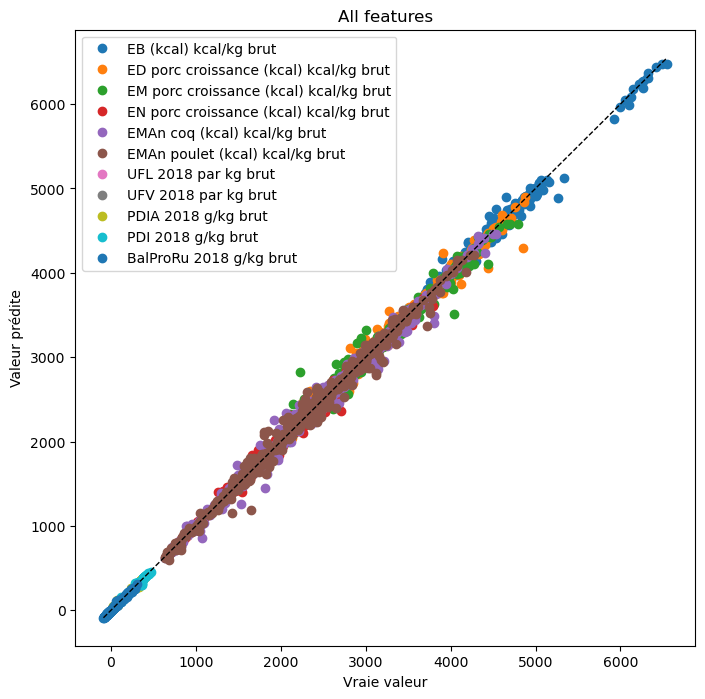

In [121]:
plot_pred_vs_true(models_all, X_test_all, y_test_all, vars_cibles, title="All features", n=0)

### XGBoost Model | variables explicatives : MS % brut & PB % brut

In [123]:
# Sélectionner uniquement les variables explicatives
vars_expl_selected = ["MS % brut", "PB % brut"]

# Préparation des données
X_train, X_test, y_train, y_test = prepare_data_random_split(
    data, vars_expl_selected, vars_cibles, test_size=0.2, random_state=42
)

# Entraînement des modèles
resultats_MS_PB_df, models_sel = train_xgboost_models(
    X_train, X_test, y_train, y_test, 
    vars_cibles, noms_simplifies, random_state=42
)

print("Résultats du modèle avec MS, PB:")
print(f"Nombre d'observations en train: {len(X_train)}")
print(f"Nombre d'observations en test: {len(X_test)}")
print(resultats_MS_PB_df.to_string(index=False))

Résultats du modèle avec MS, PB:
Nombre d'observations en train: 3198
Nombre d'observations en test: 800
Variable cible    MAE   RMSE     R2
            EB 180.97 366.77 0.4134
       ED porc 345.08 524.85 0.2722
       EM porc 340.79 518.93 0.2263
       EN porc 325.85 523.88 0.0682
      EMAn coq 425.34 688.55 0.2055
   EMAn poulet 408.15 652.66 0.2436
           UFL   0.11   0.17 0.2411
           UFV   0.13   0.19 0.2214
          PDIA  14.07  27.16 0.8935
           PDI  13.17  25.78 0.8983
      BalProRu  15.26  27.77 0.9111


                        Variable cible  Vraie valeur  Valeur prédite
                EB (kcal) kcal/kg brut       3850.00     3781.965820
ED porc croissance (kcal) kcal/kg brut       3370.00     3358.100830
EM porc croissance (kcal) kcal/kg brut       3290.00     3263.253418
EN porc croissance (kcal) kcal/kg brut       2630.00     2479.843506
          EMAn coq (kcal) kcal/kg brut       3140.00     3015.965820
       EMAn poulet (kcal) kcal/kg brut       3070.00     3042.428711
                  UFL 2018 par kg brut          1.11        1.075472
                  UFV 2018 par kg brut          1.14        1.089794
                   PDIA 2018 g/kg brut         34.00       32.676212
                    PDI 2018 g/kg brut         80.00       78.316849
               BalProRu 2018 g/kg brut        -52.00      -49.523315


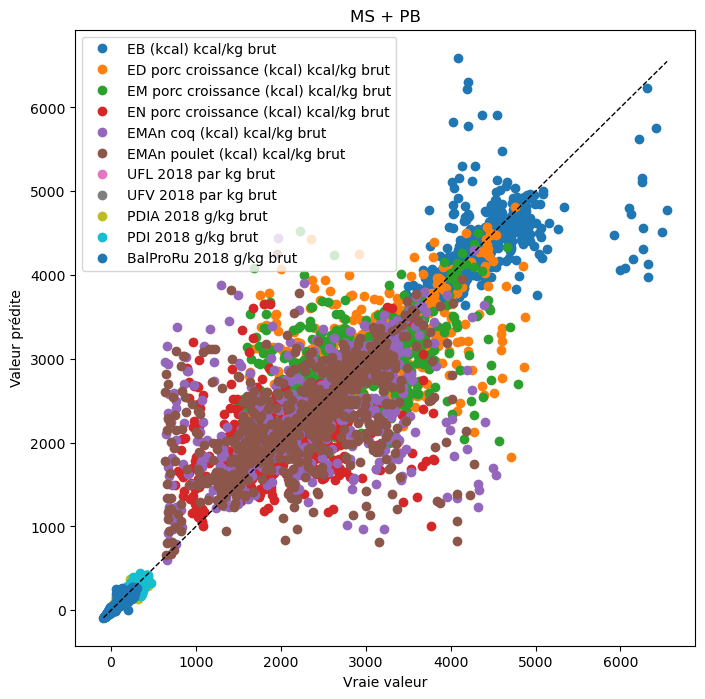

In [126]:
plot_pred_vs_true(models_sel, X_test, y_test, vars_cibles, title="MS + PB", n=0)

### XGBoost Model | variables explicatives : MS % brut & PB % brut & Classe encoded

In [127]:
# Variables explicatives sélectionnées
vars_expl_with_classe = ["MS % brut", "PB % brut"]

# Préparation des données avec split aléatoire
X_train_sel, X_test_sel, y_train_sel, y_test_sel = prepare_data_random_split(
    data, vars_expl_with_classe, vars_cibles, test_size=0.2, random_state=42
)

# Indices pour la feature encodée
indices_train = X_train_sel.index
indices_test = X_test_sel.index

# Ajouter la variable Classe encodée
X_train_sel, X_test_sel = add_encoded_feature(
    X_train_sel, X_test_sel, data, "Classe", indices_train, indices_test
)

# Entraînement des modèles
resultats_MS_PB_Classe_df, models_sel_class = train_xgboost_models(
    X_train_sel, X_test_sel, y_train_sel, y_test_sel, 
    vars_cibles, noms_simplifies, random_state=42
)

print("Résultats du modèle avec MS, PB et Classe:")
print(f"Nombre d'observations en train: {len(X_train_sel)}")
print(f"Nombre d'observations en test: {len(X_test_sel)}")
print(resultats_MS_PB_Classe_df.to_string(index=False))

Résultats du modèle avec MS, PB et Classe:
Nombre d'observations en train: 3198
Nombre d'observations en test: 800
Variable cible    MAE   RMSE     R2
            EB  80.03 138.15 0.9168
       ED porc 161.60 247.71 0.8379
       EM porc 157.74 245.10 0.8274
       EN porc 140.82 217.58 0.8393
      EMAn coq 164.43 256.08 0.8901
   EMAn poulet 175.74 267.87 0.8726
           UFL   0.05   0.08 0.8463
           UFV   0.06   0.09 0.8338
          PDIA   5.05  11.89 0.9796
           PDI   5.24  12.32 0.9768
      BalProRu   6.07  12.43 0.9822


                        Variable cible  Vraie valeur  Valeur prédite
                EB (kcal) kcal/kg brut       3850.00     3858.773438
ED porc croissance (kcal) kcal/kg brut       3370.00     3401.673584
EM porc croissance (kcal) kcal/kg brut       3290.00     3301.622070
EN porc croissance (kcal) kcal/kg brut       2630.00     2662.760742
          EMAn coq (kcal) kcal/kg brut       3140.00     3206.417725
       EMAn poulet (kcal) kcal/kg brut       3070.00     3159.104248
                  UFL 2018 par kg brut          1.11        1.107623
                  UFV 2018 par kg brut          1.14        1.140764
                   PDIA 2018 g/kg brut         34.00       35.872326
                    PDI 2018 g/kg brut         80.00       78.103523
               BalProRu 2018 g/kg brut        -52.00      -51.187534


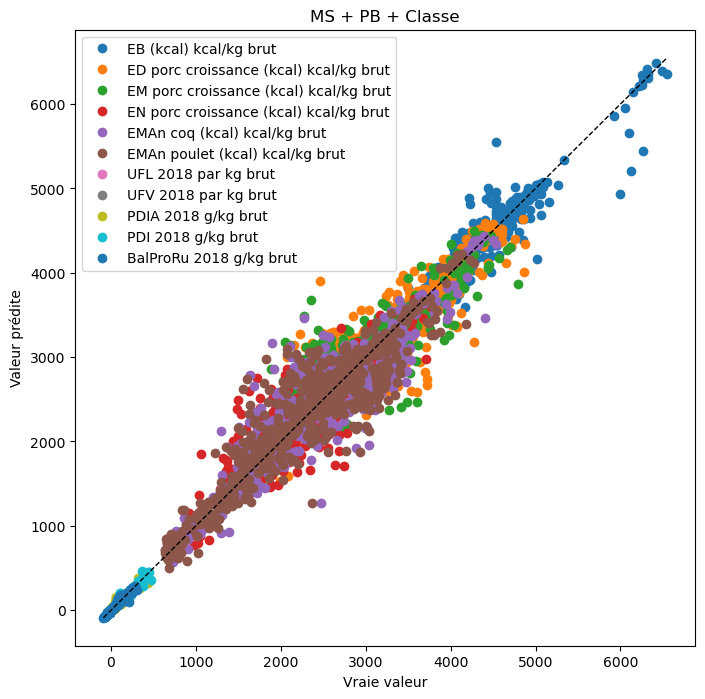

In [128]:
plot_pred_vs_true(models_sel_class, X_test_sel, y_test_sel, vars_cibles, title="MS + PB + Classe", n=0)

### XGBoost Model | variables explicatives : MS % brut & PB % brut & Classe encoded
### Un Nom par Classe caché à l'entrainement et utilisé en test uniquement pour voir l'impact sur la performance du modèle d'un produit inconnu assimilé à une classe existante.

In [129]:
# Variables explicatives sélectionnées
vars_expl_hide = ["MS % brut", "PB % brut"]

# Préparation des données en cachant 1 produit par classe
X_train_hide, X_test_hide, y_train_hide, y_test_hide, classe_test, nom_test = prepare_data_hide_one_per_class(
    data, vars_expl_hide, vars_cibles, "Classe", random_state=42
)

# Obtenir les indices pour l'ajout de la feature encodée
indices_train_hide = X_train_hide.index
indices_test_hide = X_test_hide.index

# Ajouter la variable Classe encodée
X_train_hide, X_test_hide = add_encoded_feature(
    X_train_hide, X_test_hide, data, "Classe", indices_train_hide, indices_test_hide
)

# Entraînement des modèles
resultats_hide_df, models_hide_name_class = train_xgboost_models(
    X_train_hide, X_test_hide, y_train_hide, y_test_hide, 
    vars_cibles, noms_simplifies, random_state=42
)

print(f"Nombre d'observations en train: {len(X_train_hide)}")
print(f"Nombre d'observations en test: {len(X_test_hide)}")
print("Résultats du modèle avec MS, PB et Classe:")
print(resultats_hide_df.to_string(index=False))
print()

# Afficher les produits cachés à l'entraînement
display_hidden_products(classe_test, nom_test)

Nombre d'observations en train: 2882
Nombre d'observations en test: 1116
Résultats du modèle avec MS, PB et Classe:
Variable cible    MAE    RMSE      R2
            EB 316.54  473.06 -0.8315
       ED porc 707.39  920.59 -0.5843
       EM porc 698.27  915.80 -0.6888
       EN porc 696.22  934.85 -1.1583
      EMAn coq 866.18 1119.98 -0.6916
   EMAn poulet 863.07 1181.83 -0.9891
           UFL   0.20    0.27 -1.4385
           UFV   0.21    0.29 -1.0128
          PDIA  36.41   62.20  0.3846
           PDI  35.13   62.36  0.3246
      BalProRu  33.64   54.78  0.7623

Produits de test (cachés à l'entraînement):
                                Classe                                                   Nom
                              Céréales                                            Triticale 
              Autres produits végétaux                                       Coques de soja 
        Autres coproduits des céréales                            Coproduits de biscuiterie 
           

                        Variable cible  Vraie valeur  Valeur prédite
                EB (kcal) kcal/kg brut       3740.00     4046.820068
ED porc croissance (kcal) kcal/kg brut       3200.00     2906.479492
EM porc croissance (kcal) kcal/kg brut       3100.00     2823.880859
EN porc croissance (kcal) kcal/kg brut       2420.00     2135.733154
          EMAn coq (kcal) kcal/kg brut       2890.00     2802.765625
       EMAn poulet (kcal) kcal/kg brut       2770.00     2691.242432
                  UFL 2018 par kg brut          1.02        0.933638
                  UFV 2018 par kg brut          1.03        0.923245
                   PDIA 2018 g/kg brut         21.00       26.530960
                    PDI 2018 g/kg brut         75.00       74.523178
               BalProRu 2018 g/kg brut        -16.00      -14.514355


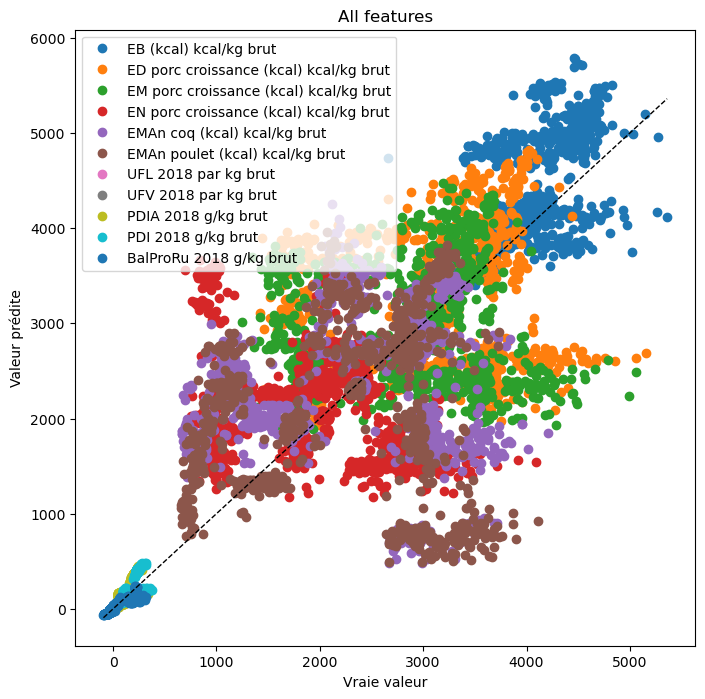

In [130]:
plot_pred_vs_true(models_hide_name_class, X_test_hide, y_test_hide, vars_cibles, title="All features", n=0)

### XGBoost Model | variables explicatives : All features & Classe encoded
### Un Nom par Classe caché à l'entrainement et utilisé en test uniquement pour voir l'impact sur la performance du modèle d'un produit inconnu assimilé à une classe existante.

In [131]:
# Préparation des données en cachant 1 produit par classe
X_train_hide_all, X_test_hide_all, y_train_hide_all, y_test_hide_all, classe_test_all, nom_test_all = prepare_data_hide_one_per_class(
    data, vars_expl, vars_cibles, "Classe", random_state=42
)

# Obtenir les indices pour l'ajout de la feature encodée
indices_train_hide_all = X_train_hide_all.index
indices_test_hide_all = X_test_hide_all.index

# Ajouter la variable Classe encodée
X_train_hide_all, X_test_hide_all = add_encoded_feature(
    X_train_hide_all, X_test_hide_all, data, "Classe", indices_train_hide_all, indices_test_hide_all
)

# Entraînement des modèles
resultats_hide_all_df, models_hide_all_name_class = train_xgboost_models(
    X_train_hide_all, X_test_hide_all, y_train_hide_all, y_test_hide_all,
    vars_cibles, noms_simplifies, random_state=42
)

print(f"Nombre d'observations en train: {len(X_train_hide_all)}")
print(f"Nombre d'observations en test: {len(X_test_hide_all)}")
print("Résultats du modèle avec All features et Classe:")
print(resultats_hide_all_df.to_string(index=False))
print()

# Afficher les produits cachés à l'entraînement
display_hidden_products(classe_test_all, nom_test_all)

Nombre d'observations en train: 2882
Nombre d'observations en test: 1116
Résultats du modèle avec All features et Classe:
Variable cible    MAE   RMSE      R2
            EB 197.44 321.48  0.1541
       ED porc 307.18 515.26  0.5037
       EM porc 281.98 508.14  0.4801
       EN porc 184.78 284.58  0.8000
      EMAn coq 314.82 394.15  0.7905
   EMAn poulet 370.94 477.27  0.6756
           UFL   0.14   0.21 -0.4028
           UFV   0.14   0.20  0.0524
          PDIA  36.61  65.84  0.3105
           PDI  35.30  63.86  0.2918
      BalProRu  35.61  58.22  0.7315

Produits de test (cachés à l'entraînement):
                                Classe                                                   Nom
                              Céréales                                            Triticale 
              Autres produits végétaux                                       Coques de soja 
        Autres coproduits des céréales                            Coproduits de biscuiterie 
                 

                        Variable cible  Vraie valeur  Valeur prédite
                EB (kcal) kcal/kg brut       3740.00     3759.771729
ED porc croissance (kcal) kcal/kg brut       3200.00     3228.574463
EM porc croissance (kcal) kcal/kg brut       3100.00     3124.277588
EN porc croissance (kcal) kcal/kg brut       2420.00     2420.439941
          EMAn coq (kcal) kcal/kg brut       2890.00     2793.689453
       EMAn poulet (kcal) kcal/kg brut       2770.00     2404.490723
                  UFL 2018 par kg brut          1.02        1.030980
                  UFV 2018 par kg brut          1.03        1.041341
                   PDIA 2018 g/kg brut         21.00       20.355135
                    PDI 2018 g/kg brut         75.00       74.816467
               BalProRu 2018 g/kg brut        -16.00      -15.925352


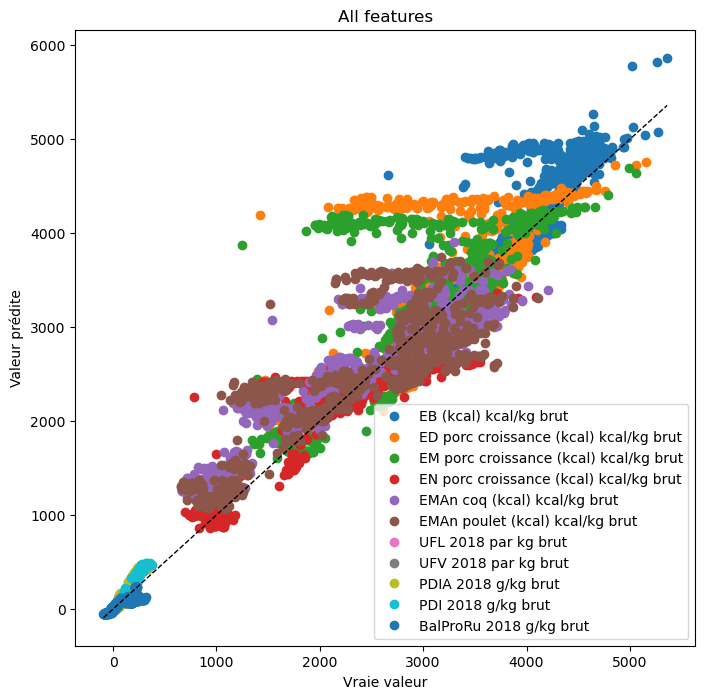

In [132]:
plot_pred_vs_true(models_hide_all_name_class, X_test_hide_all, y_test_hide_all, vars_cibles, title="All features", n=0)

### XGBoost Model | variables explicatives : MS % brut & PB % brut
### Une Classe cachée à l'entrainement et utilisée en test uniquement pour voir l'impact sur la performance du modèle d'une nouvelle classe inconnue.

In [133]:
# Variables explicatives sélectionnées
vars_expl_hide_class = ["MS % brut", "PB % brut"]

# Préparer les données en masquant une classe entière
# Sélectionner une classe à masquer (première classe par ordre d'apparition)
classe_a_masquer = data['Classe'].unique()[0]

# Indices train et test
indices_train_class = data[data['Classe'] != classe_a_masquer].index
indices_test_class = data[data['Classe'] == classe_a_masquer].index

X_train_class = data.loc[indices_train_class, vars_expl_hide_class].copy()
y_train_class = data.loc[indices_train_class, vars_cibles].copy()

X_test_class = data.loc[indices_test_class, vars_expl_hide_class].copy()
y_test_class = data.loc[indices_test_class, vars_cibles].copy()

# Ajouter la variable Classe encodée
X_train_class, X_test_class = add_encoded_feature(
    X_train_class, X_test_class, data, "Classe", indices_train_class, indices_test_class
)

# Entraînement des modèles
resultats_hide_class_df, models_hide_class_sel = train_xgboost_models(
    X_train_class, X_test_class, y_train_class, y_test_class, 
    vars_cibles, noms_simplifies, random_state=42
)

print(f"Classe masquée à l'entraînement: {classe_a_masquer}")
print(f"Nombre d'observations en train: {len(X_train_class)}")
print(f"Nombre d'observations en test: {len(X_test_class)}")
print()
print("Résultats du modèle avec classe entière masquée:")
print(resultats_hide_class_df.to_string(index=False))

Classe masquée à l'entraînement: Céréales
Nombre d'observations en train: 3308
Nombre d'observations en test: 690

Résultats du modèle avec classe entière masquée:
Variable cible    MAE   RMSE      R2
            EB 112.96 125.67  0.0835
       ED porc 292.10 395.81 -1.5999
       EM porc 304.85 406.19 -1.6658
       EN porc 281.51 380.86 -1.6967
      EMAn coq 380.34 491.31 -1.9226
   EMAn poulet 403.44 501.16 -1.1868
           UFL   0.07   0.08 -0.3295
           UFV   0.08   0.10 -0.2117
          PDIA   8.67   9.28 -0.2034
           PDI   5.70   6.95 -0.2045
      BalProRu   6.11   8.73  0.6265


                        Variable cible  Vraie valeur  Valeur prédite
                EB (kcal) kcal/kg brut       3920.00     3901.260498
ED porc croissance (kcal) kcal/kg brut       2460.00     3387.619385
EM porc croissance (kcal) kcal/kg brut       2380.00     3259.971436
EN porc croissance (kcal) kcal/kg brut       1850.00     2574.872803
          EMAn coq (kcal) kcal/kg brut       2610.00     2847.518799
       EMAn poulet (kcal) kcal/kg brut       2480.00     2640.423584
                  UFL 2018 par kg brut          0.81        1.013788
                  UFV 2018 par kg brut          0.76        1.008532
                   PDIA 2018 g/kg brut         17.00       28.288408
                    PDI 2018 g/kg brut         62.00       77.046646
               BalProRu 2018 g/kg brut        -10.00      -22.260551


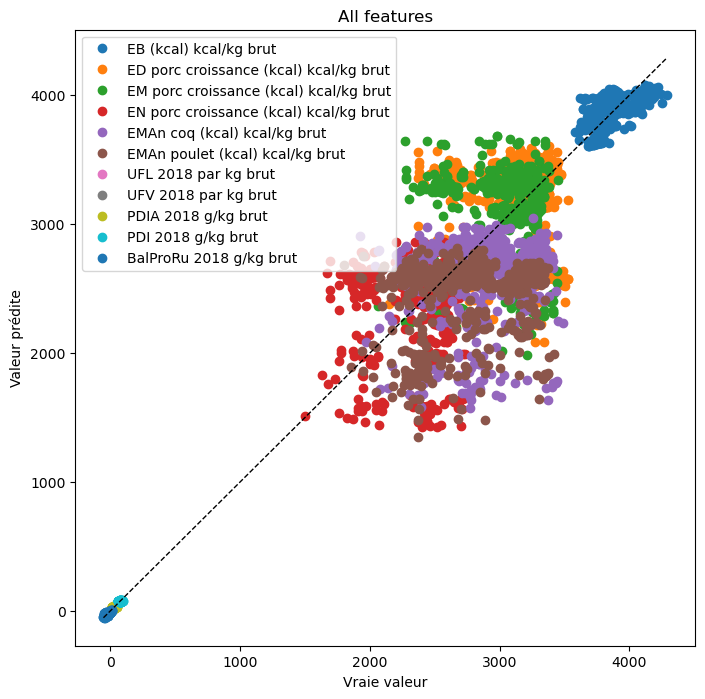

In [134]:
plot_pred_vs_true(models_hide_class_sel, X_test_class, y_test_class, vars_cibles, title="All features", n=0)

### XGBoost Model | variables explicatives : All features
### Une Classe cachée à l'entrainement et utilisée en test uniquement pour voir l'impact sur la performance du modèle d'une nouvelle classe inconnue.

In [135]:
# Préparer les données en masquant une classe entière
# Sélectionner une classe à masquer (première classe par ordre d'apparition)
classe_a_masquer = data['Classe'].unique()[0]

# Indices train et test
indices_train_class = data[data['Classe'] != classe_a_masquer].index
indices_test_class = data[data['Classe'] == classe_a_masquer].index

X_train_class = data.loc[indices_train_class, vars_expl].copy()
y_train_class = data.loc[indices_train_class, vars_cibles].copy()

X_test_class = data.loc[indices_test_class, vars_expl].copy()
y_test_class = data.loc[indices_test_class, vars_cibles].copy()

# Ajouter la variable Classe encodée
X_train_class, X_test_class = add_encoded_feature(
    X_train_class, X_test_class, data, "Classe", indices_train_class, indices_test_class
)

# Entraînement des modèles
resultats_hide_class_df, models_hide_class_all = train_xgboost_models(
    X_train_class, X_test_class, y_train_class, y_test_class, 
    vars_cibles, noms_simplifies, random_state=42
)

print(f"Classe masquée à l'entraînement: {classe_a_masquer}")
print(f"Nombre d'observations en train: {len(X_train_class)}")
print(f"Nombre d'observations en test: {len(X_test_class)}")
print()
print("Résultats du modèle avec classe entière masquée:")
print(resultats_hide_class_df.to_string(index=False))

Classe masquée à l'entraînement: Céréales
Nombre d'observations en train: 3308
Nombre d'observations en test: 690

Résultats du modèle avec classe entière masquée:
Variable cible    MAE   RMSE      R2
            EB  35.82  45.97  0.8774
       ED porc 324.90 338.16 -0.8977
       EM porc 144.64 177.52  0.4908
       EN porc  59.56  75.25  0.8947
      EMAn coq 180.83 245.15  0.2724
   EMAn poulet 227.02 289.90  0.2683
           UFL   0.04   0.05  0.4667
           UFV   0.06   0.08  0.3183
          PDIA   7.90  11.13 -0.7306
           PDI   5.78   7.11 -0.2587
      BalProRu   6.58   9.20  0.5852


                        Variable cible  Vraie valeur  Valeur prédite
                EB (kcal) kcal/kg brut       3920.00     3841.158936
ED porc croissance (kcal) kcal/kg brut       2460.00     2403.733398
EM porc croissance (kcal) kcal/kg brut       2380.00     2244.219971
EN porc croissance (kcal) kcal/kg brut       1850.00     1488.067505
          EMAn coq (kcal) kcal/kg brut       2610.00     1715.323730
       EMAn poulet (kcal) kcal/kg brut       2480.00     1642.631714
                  UFL 2018 par kg brut          0.81        0.945912
                  UFV 2018 par kg brut          0.76        0.952806
                   PDIA 2018 g/kg brut         17.00       23.640253
                    PDI 2018 g/kg brut         62.00       71.239861
               BalProRu 2018 g/kg brut        -10.00      -23.476160


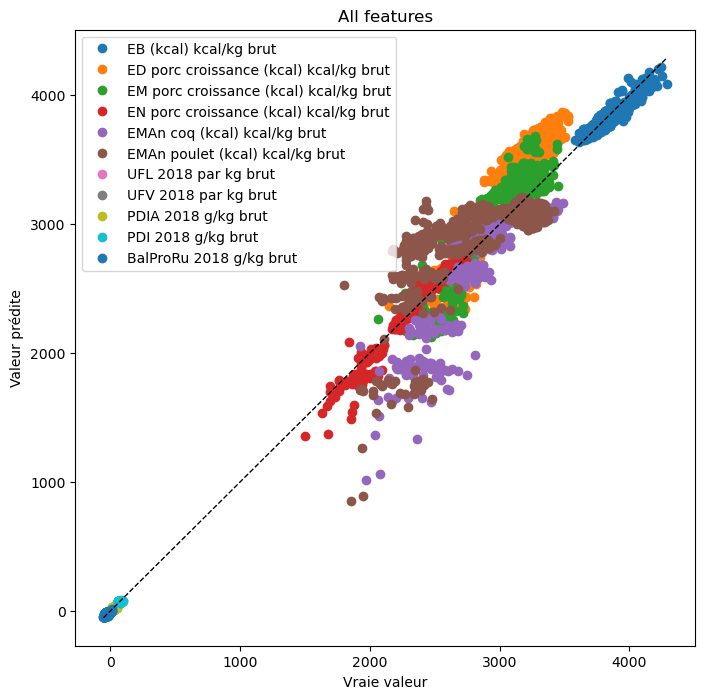

In [136]:
plot_pred_vs_true(models_hide_class_all, X_test_class, y_test_class, vars_cibles, title="All features", n=0)

In [137]:
# Synthèse complète des résultats de tous les modèles
synthese_resultats = pd.DataFrame({
    'Modèle': [
        'All features (Random split)',
        'MS + PB (Random split)',
        'MS + PB + Classe (Random split)',
        'MS + PB + Classe (Hidden products)',
        'All features + Classe (Hidden products)',
        'MS + PB + Classe (Hidden class)',
        'All features + Classe (Hidden class)'
    ],
    'Nombre obs. train': [
        len(X_train_all),
        len(X_train),
        len(X_train_sel),
        len(X_train_hide),  # from hidden products MS+PB
        len(X_train_hide_all),  # from hidden products with all features
        len(X_train_class),
        len(X_train_class)
    ],
    'Nombre obs. test': [
        len(X_test_all),
        len(X_test),
        len(X_test_sel),
        len(X_test_hide),  # from hidden products MS+PB
        len(X_test_hide_all),  # from hidden products with all features
        len(X_test_class),
        len(X_test_class)
    ],
    'R² EB': [
        resultats_all_df[resultats_all_df['Variable cible'] == 'EB']['R2'].values[0],
        resultats_MS_PB_df[resultats_MS_PB_df['Variable cible'] == 'EB']['R2'].values[0],
        resultats_MS_PB_Classe_df[resultats_MS_PB_Classe_df['Variable cible'] == 'EB']['R2'].values[0],
        resultats_hide_df[resultats_hide_df['Variable cible'] == 'EB']['R2'].values[0],
        resultats_hide_all_df[resultats_hide_all_df['Variable cible'] == 'EB']['R2'].values[0],
        resultats_hide_class_df[resultats_hide_class_df['Variable cible'] == 'EB']['R2'].values[0],
        resultats_hide_class_df[resultats_hide_class_df['Variable cible'] == 'EB']['R2'].values[0]
    ],
    'R² ED porc': [
        resultats_all_df[resultats_all_df['Variable cible'] == 'ED porc']['R2'].values[0],
        resultats_MS_PB_df[resultats_MS_PB_df['Variable cible'] == 'ED porc']['R2'].values[0],
        resultats_MS_PB_Classe_df[resultats_MS_PB_Classe_df['Variable cible'] == 'ED porc']['R2'].values[0],
        resultats_hide_df[resultats_hide_df['Variable cible'] == 'ED porc']['R2'].values[0],
        resultats_hide_all_df[resultats_hide_all_df['Variable cible'] == 'ED porc']['R2'].values[0],
        resultats_hide_class_df[resultats_hide_class_df['Variable cible'] == 'ED porc']['R2'].values[0],
        resultats_hide_class_df[resultats_hide_class_df['Variable cible'] == 'ED porc']['R2'].values[0]
    ],
    'R² EM porc': [
        resultats_all_df[resultats_all_df['Variable cible'] == 'EM porc']['R2'].values[0],
        resultats_MS_PB_df[resultats_MS_PB_df['Variable cible'] == 'EM porc']['R2'].values[0],
        resultats_MS_PB_Classe_df[resultats_MS_PB_Classe_df['Variable cible'] == 'EM porc']['R2'].values[0],
        resultats_hide_df[resultats_hide_df['Variable cible'] == 'EM porc']['R2'].values[0],
        resultats_hide_all_df[resultats_hide_all_df['Variable cible'] == 'EM porc']['R2'].values[0],
        resultats_hide_class_df[resultats_hide_class_df['Variable cible'] == 'EM porc']['R2'].values[0],
        resultats_hide_class_df[resultats_hide_class_df['Variable cible'] == 'EM porc']['R2'].values[0]
    ],
    'R² EN porc': [
        resultats_all_df[resultats_all_df['Variable cible'] == 'EN porc']['R2'].values[0],
        resultats_MS_PB_df[resultats_MS_PB_df['Variable cible'] == 'EN porc']['R2'].values[0],
        resultats_MS_PB_Classe_df[resultats_MS_PB_Classe_df['Variable cible'] == 'EN porc']['R2'].values[0],
        resultats_hide_df[resultats_hide_df['Variable cible'] == 'EN porc']['R2'].values[0],
        resultats_hide_all_df[resultats_hide_all_df['Variable cible'] == 'EN porc']['R2'].values[0],
        resultats_hide_class_df[resultats_hide_class_df['Variable cible'] == 'EN porc']['R2'].values[0],
        resultats_hide_class_df[resultats_hide_class_df['Variable cible'] == 'EN porc']['R2'].values[0]
    ],
})

print("=" * 120)
print("SYNTHÈSE COMPLÈTE DES RÉSULTATS")
print("=" * 120)
print(synthese_resultats.to_string(index=False))
print()

SYNTHÈSE COMPLÈTE DES RÉSULTATS
                                 Modèle  Nombre obs. train  Nombre obs. test   R² EB  R² ED porc  R² EM porc  R² EN porc
            All features (Random split)               3198               800  0.9930      0.9917      0.9896      0.9950
                 MS + PB (Random split)               3198               800  0.4134      0.2722      0.2263      0.0682
        MS + PB + Classe (Random split)               3198               800  0.9168      0.8379      0.8274      0.8393
     MS + PB + Classe (Hidden products)               2882              1116 -0.8315     -0.5843     -0.6888     -1.1583
All features + Classe (Hidden products)               2882              1116  0.1541      0.5037      0.4801      0.8000
        MS + PB + Classe (Hidden class)               3308               690  0.8774     -0.8977      0.4908      0.8947
   All features + Classe (Hidden class)               3308               690  0.8774     -0.8977      0.4908      0.8947
